## TensorFlow Speech Recognition Challenge

This noetbook explains speech recognition model for single word detection in TensorFlow Speech Recognition Challenge.

* https://www.kaggle.com/c/tensorflow-speech-recognition-challenge

In [1]:
# for toggle input
# https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

# 1. Description

TensorFlow released dataset Speech Commands Datasets to help with building a voice recogntion model. It includes 65,000 one-second long utterances of 30 short words, by thousands of different people.

There are only 12 possible labels for the Test set: yes, no, up, down, left, right, on, off, stop, go, silence, unknown. The unknown label should be used for a command that is not one one of the first 10 labels or that is not silence.

Competition has been already finished long ago, but I built a model with this datasets for my study.

## Metrics

* https://www.kaggle.com/c/tensorflow-speech-recognition-challenge#evaluation

Submissions were evaluated on Multiclass Accuracy, which was simply the average number of observations with the correct label.

# 2. Analysis

##  2.1. Train data exploration

### 2.1.1. sampling rate, channel, and duration
As commands below, almost audio's duration are 1sec, all audio's number of channel are 1, and all audio's sampling rate are 16 kHz. 

> #duration  
> \$ find train/audio/ -name "*wav" | xargs mediainfo | grep Duration | grep  ": 1 s 0 ms" | wc -l  
> 116800  
> \$ find train/audio/ -name "*wav" | xargs mediainfo | grep Duration | grep  -v ": 1 s 0 ms" | wc -l  
> 12952  
> #channel  
> \$ find train/audio/ -name "*wav" | xargs mediainfo | grep Channel | grep -v "1 channel"  
> \$ echo \$?    
> 1  
> #sampling rate  
> \$ find train/audio/ -name "*wav" | xargs mediainfo | grep "Sampling rate" | grep -v ": 16.0 kHz"  
> \$ echo \$?  
> 1  

> \# for duration histogram  
> \$ find train/audio/ -name "*wav" | xargs mediainfo | grep Duration | awk -F: '{print $2}' > durationlist.txt

Duration histogram is below.

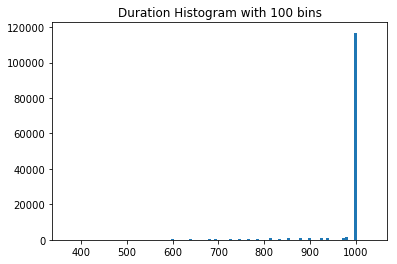

In [2]:
# @hidden_cell
import matplotlib.pyplot as plt

durations = []
# parse durationlist.txt
# format: [ n s] m ms
with open('durationlist.txt') as f:
    for line in f.readlines():
        items = line.strip().split()
        if len(items) == 2:
            duration = int(items[0])
        elif len(items) == 4:
            duration = int(items[2])
            duration = duration + int(items[0]) * 1000
        durations.append(duration)

# display histogram
plt.hist(durations, bins=100)
plt.title("Duration Histogram with 100 bins")
plt.show()
hide_toggle()

### 2.1.2. Number of files for each word

All main words have 2300 ~ 2400 audio files.

> \$ for dir in \$(find train/audio/ -mindepth 1 -maxdepth 1 -name "*"); do echo -n "> \$(basename \$dir): "; ls -1 \$dir/ | wc -l; done | sort  
> _background_noise_: 7  
> bed: 1713  
> bird: 1731  
> cat: 1733  
> dog: 1746  
> down: 2359  
> eight: 2352  
> five: 2357  
> four: 2372  
> go: 2372  
> happy: 1742  
> house: 1750  
> left: 2353  
> marvin: 1746  
> nine: 2364  
> no: 2375  
> off: 2377  
> on: 2391  
> one: 2390  
> right: 2367  
> seven: 2377  
> sheila: 1758  
> six: 2369  
> stop: 2400  
> three: 2376  
> tree: 1733  
> two: 2394  
> up: 2375  
> wow: 1745  
> yes: 2377  
> zero: 2376  

## 2.2. Exploratory Visualization
### 2.2.1. Sample's audio spectrogram 

In [3]:
# load general libraries
import mpl_toolkits  # import before pathlib
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from tensorflow import set_random_seed

import pickle
import wave

# load analysis and modeling scripts
from os.path import dirname, join, abspath
sys.path.insert(0, abspath(join(dirname('.'), 'src')))

from single_word_model import *
from train_model import *
from dataset import *
%matplotlib inline

hide_toggle()

Using TensorFlow backend.


In [4]:
# load train data
raw_data_path = 'raw_data_with_lfbe.pickle'
with open(raw_data_path, 'rb') as f:
    raw_data = pickle.load(f)

hide_toggle()

'one' file:5c39594f_nohash_4.wav start:486 end:749


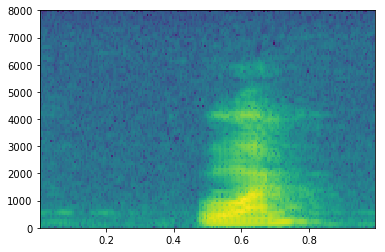

In [5]:
audio = raw_data.keywords['one'][4]
print(f"'one' file:{audio.filename} start:{audio.start_ms} end:{audio.end_ms}")

filename = 'train/audio/one/' + audio.filename
graph_spectrogram(filename)
IPython.display.Audio(filename)

hide_toggle()

After checking a few audio data, I realized background noise is low. Therefore, to a make robust model, background noise need to be inserted into train dataset.

## 2.3. Algorithms and Techniques

* https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43969.pdf
* https://arxiv.org/pdf/1803.03759.pdf

To create models, I referred the papers above.

### 2.3.1. feature extraction

Log Mel-filterbank energy features is abopted. The number of filters (dimension) is 40. The length of the analysis window in seconds is 0.025. The step between successive windows in seconds is 0.010. The implementation is python_speech_features below.

* https://python-speech-features.readthedocs.io/en/latest/#python_speech_features.base.logfbank

### 2.3.2. neural network model

In this study, I did not consider creating light weight model. I just accumrated cnn, and max pooling layers.
Frontend is Keras and backend is TensorFlow.

* https://keras.io/layers/convolutional/
* https://keras.io/layers/pooling/

# 3. Methodology
## 3.1. Data Preprocessing
### 3.1.1 Insert noise

I referre to Coursera DeepLearning couse sample code about how to insert background noise. Basic procedure is below.

1. extract background audio at random position.
2. add randomly selected word audio to extracted background's random position.  
  


* https://www.coursera.org/learn/nlp-sequence-models


To mix multiple audio, pydub is used.

* https://github.com/jiaaro/pydub


### 3.2. Model

The implementation of model is below. There are 4 CNN and MaxPooling Layers finally. 

In [6]:
def create_model_cnn(input_shape, class_num=command.NUM_CLASSES,
                     dropout=0.5, is_train=True):
    """
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    class_num   -- number of output classes
    dropout     -- dropout ratio
    is_train    -- whether set dropout
    Returns:
    model -- Keras model instance
    """

    x_input = Input(shape=input_shape)
    x = Reshape((Tx, 40))(x_input)

    x = Conv1D(filters=32, kernel_size=(5,), padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU(alpha=0.05)(x)
    x = MaxPooling1D(pool_size=(5,), strides=(2,))(x)

    x = Conv1D(filters=64, kernel_size=(5,), padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU(alpha=0.05)(x)
    x = MaxPooling1D(pool_size=(3,), strides=(2,))(x)

    x = Conv1D(filters=128, kernel_size=(5,), padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU(alpha=0.05)(x)
    x = MaxPooling1D(pool_size=(3,), strides=(1,))(x)

    x = Conv1D(filters=196, kernel_size=(3,), padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU(alpha=0.05)(x)
    x = MaxPooling1D(pool_size=(2,), strides=(1,))(x)

    x = Dense(1024, activation=elu)(x)
    if is_train:
        x = Dropout(dropout)(x)
    x = Flatten()(x)
    x = Dense(class_num, activation='softmax')(x)
    model = Model(inputs=x_input, outputs=x)
    model.output_length = lambda v: cnn_output_length(v, filter_size=128, border_mode='causal',
                                                      stride=1, dilation=2)
    return model


# 4. Result
## 4.1. Model vaidation

Model comparision process is skipped. I would just post the final model's validation loss and accuracy.

In [7]:
np.random.seed(19)
set_random_seed(19)

raw_data_path = f"raw_data_with_{FEATURE_TYPE}.pickle"

with open(raw_data_path, 'rb') as f:
    raw_data = pickle.load(f)

weight_param_path = f"model/kmn_kaggle_cnn_1sec_{FEATURE_TYPE}.weights.best.hdf5"
model = build_model(weight_param_path, create_model=create_model_cnn)
model.summary()

for i in range(0, 2):
    train_model(model, raw_data, weight_param_path,
                detect_wakeword=True,
                feature_type=FEATURE_TYPE)


input shape=(99, 40)
load weights: file=model/kmn_kaggle_cnn_1sec_lfbe.weights.best.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 99, 40)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 99, 40)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 99, 32)            6432      
_________________________________________________________________
batch_normalization_1 (Batch (None, 99, 32)            128       
_________________________________________________________________
elu_1 (ELU)                  (None, 99, 32)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 32)            0         
_____________________________________________________

The best validation los is 0.0406 and validation accuracy is 0.9892.

## 4.2. Model check



In [8]:
test_model = create_model_cnn(input_shape=(Tx, n_freq), is_train=True)
test_model.load_weights(weight_param_path)

# stop
test_wave = 'test/audio/clip_0a0c03051.wav'

def predict(test_wave, test_model):
    x = create_features(test_wave, FEATURE_TYPE)
    # padding shortage space
    if x.shape[0] < Tx:
        # calc remaining space size
        empty_space_size = Tx - x.shape[0]
        # create remaining space
        empty_space = np.zeros((empty_space_size, n_freq), dtype=np.float32)
        # complement data's empty space
        x = np.concatenate((x, empty_space), axis=0)
    x = np.float32(np.array([x]))

    # predict
    predicted = test_model.predict(x)
    pred_y = np.argmax(predicted[0], axis=0)
    predicted_word = command.REVERSE_KEYWORDS_MAP[pred_y]
    return pred_y, predicted_word

pred_y, predicted_word = predict(test_wave, test_model)
print(f"sample 'stop':: index:{pred_y} predicted_word:{predicted_word}")

sample 'stop':: index:10 predicted_word:stop


As above, several test dataset sample could be detected.

## 4.3. create test dataset result


In [9]:
OUTPUT_FILE = 'test_dataset_prediction.txt'
DIR = './test/audio/'

content = "fname,label\n"
for test_file in os.listdir(DIR):
    test_path = os.path.join(DIR, test_file)
    if not os.path.isfile(test_path):
        continue
    pred_y, predicted_word = predict(test_path, test_model)
    content += f"{test_file},{predicted_word}\n"

with open(OUTPUT_FILE, 'w') as f:
    f.write(content)

# 5. Improvement

* fine tuning hyper parameter by grid search cross validation
* use transfer learning
* increase number of neural network layers